# Car Price Model

*Import Relevant Libraries*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

## Load Data

In [2]:
raw_data = pd.read_csv('Real_life_example.csv')
raw_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


In [3]:
raw_data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


## Preprocessing

In [4]:
raw_data.isnull().sum() # summarizes the total missing values

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
Model             0
dtype: int64

In [5]:
# rule of thumb if you are removing less than 5% of the total obsevation as a result of missing values you
# are safe
raw_data = raw_data.dropna(axis = 0) # axis 0 is for rows while axis =1 is for columns
raw_data = raw_data.drop(['Model'], axis = 1) # model is droped to prevent autocorrelation

## *Data Exploration*

*Dealing outliers*

In [6]:
P = raw_data['Price'].quantile(0.99)      # taking the 99 percentile
data_1 = raw_data[raw_data['Price'] < P]  #filtering the raw data to select price < 99 percentile 

M = data_1['Mileage'].quantile(0.99)      #filtering the data_1 to select mileage < 99 percentile 
data_2 = data_1[data_1['Mileage'] < M]

data_3 = data_2[data_2['EngineV'] < 6.5]  # filtering the data_2 to select only EngineV of <= 6.5
                                          # based on Google search highest engine volume
Y = data_3['Year'].quantile(0.01)         # filtering the data_3 to select only years > 1 percentile
data_3 = data_3[data_3['Year'] > 0.01]


In [7]:
data = data_3.reset_index(drop=True)
data.describe(include = 'all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3921,3921.000000,3921,3921.000000,3921.000000,3921,3921,3921.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,862,NaN,1499,NaN,NaN,1818,3559,NaN
mean,NaN,17988.421311,NaN,161.279776,2.443497,NaN,NaN,2006.406019
std,NaN,19041.658686,NaN,96.068269,0.946198,NaN,NaN,6.595871
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000
25%,NaN,7000.000000,NaN,92.000000,1.800000,NaN,NaN,2003.000000
50%,NaN,11500.000000,NaN,158.000000,2.200000,NaN,NaN,2008.000000
75%,NaN,21500.000000,NaN,229.000000,3.000000,NaN,NaN,2012.000000


Dealing with Multicolinearity

<AxesSubplot:>

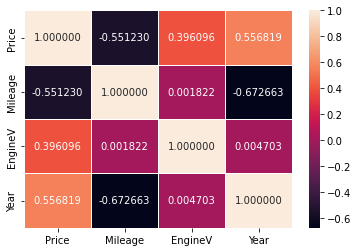

In [8]:
data_mat = data.corr()
data_mat
sns.heatmap(data_mat, linewidths=.5,annot=True, fmt="f")

The heat map shows that year and mileage have a correlation coefficient of 67%, hence its advisable to drop one. This can also be confirmed with a variance inflation factor

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = data[['Mileage', 'EngineV', 'Year']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['Features'] = variables.columns

In [10]:
vif

,VIF,Features
0,3.791073,Mileage
1,7.671170,EngineV
2,10.397185,Year


In [11]:
# from the heatmap, year and mileage are closely related hence I will drop year
# this is as a result of "year having a VIF value higher than 10"
data = data.drop(['Year'], axis = 1)

*Checking for Normality & Homoscedasity*

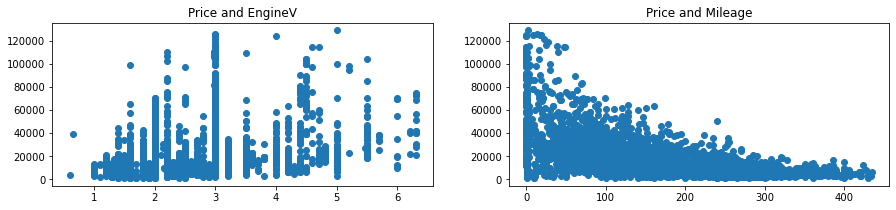

In [21]:
import mpl_toolkits.axisartist.axislines as axislines

f, (ax1, ax2) = plt.subplots(1, 2, sharey = False, figsize = (15,3))
ax1.scatter(data['EngineV'], data['Price'])
ax1.set_title('Price and EngineV')
ax2.scatter(data['Mileage'], data['Price'])
ax2.set_title('Price and Mileage')
plt.grid(False)

Relationship between Price and Engine Volume is non- linear and same applies to the relationship between Price and Mileage. 

*Relaxing Homoscedasticity*

Semi-Log transformation of Price to create a linear relationship

In [19]:
log_price = np.log(data['Price'])
data['log_price'] = log_price

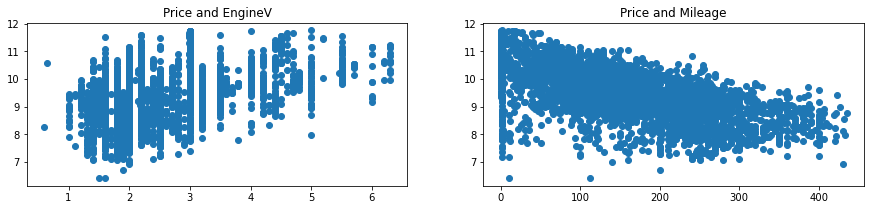

In [22]:
import mpl_toolkits.axisartist.axislines as axislines

f, (ax1, ax2) = plt.subplots(1, 2, sharey = False, figsize = (15,3))
ax1.scatter(data['EngineV'], data['log_price'])
ax1.set_title('Price and EngineV')
ax2.scatter(data['Mileage'], data['log_price'])
ax2.set_title('Price and Mileage')
plt.grid(False)

In [23]:
data = data.drop(['Price'], axis = 1) # price and log_price are multicollinear. Drop one

*Creating Dummies*

In [24]:
d_data = pd.get_dummies(data, drop_first = True) 
d_data.head()

,Mileage,EngineV,log_price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,277,2.0,8.342840,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,427,2.9,8.974618,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,358,5.0,9.495519,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,240,4.2,10.043249,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,120,2.0,9.814656,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


*Rearranging Columns*

In [25]:
d_data.columns.values

array(['Mileage', 'EngineV', 'log_price', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes'],
      dtype=object)

In [26]:
cols = ['log_price', 'Mileage', 'EngineV', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes']
d_data = d_data[cols]
d_data.head()

,log_price,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,8.342840,277,2.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,8.974618,427,2.9,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,9.495519,358,5.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,10.043249,240,4.2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,9.814656,120,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


Linear Regression

In [27]:
target = d_data['log_price']
inputs = d_data.drop(['log_price'], axis = 1)

Scale Data

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(inputs)

StandardScaler()

In [29]:
inputs_scaled = scaler.transform(inputs) # transforming to natural log 

Train Test Split

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    inputs_scaled, target, test_size = 0.2, random_state = 42) # training 80% vs testing 20%

Regression

In [31]:
reg = LinearRegression()
reg.fit(x_train, y_train)  # inputs vs target

LinearRegression()

In [32]:
yhat = reg.predict(x_train)

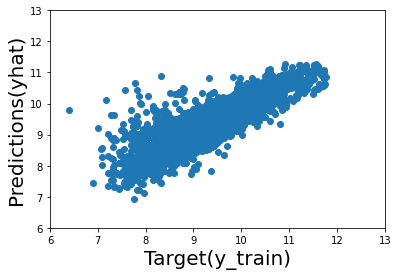

In [34]:

plt.scatter(y_train, yhat)
plt.xlabel('Target(y_train)', fontsize = 20)
plt.ylabel('Predictions(yhat)', fontsize = 20)
plt.ylim(6,13)
plt.xlim(6,13)
plt.grid(False)

Check Residuals

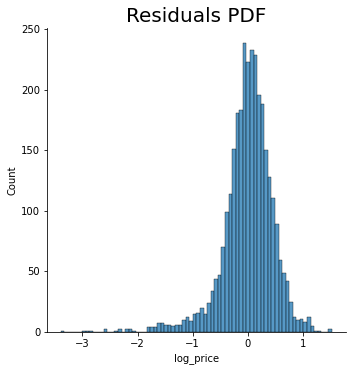

In [35]:
sns.displot(y_train - yhat)  # Residual is the difference between target & predictions
plt.title('Residuals PDF', fontsize = 20)
plt.grid(False)

Things to note so far;

* The model is not random
* The scatter plot aligns to the center
* From the residual we notice its right skew, which implies some observations(outliers) is much lower than the mean. This may cause higher price predictions than is observed. However, this shows that the predictions rarely underestimates its target (i.e. There are very few outliers to the right)

R-Square

In [36]:
reg.score(x_train, y_train)

0.733378384924122

Bias

In [37]:
reg.intercept_

9.39224529360974

In [38]:
reg.coef_

array([-0.45972063,  0.21928243,  0.02178532,  0.01788208, -0.1308216 ,
       -0.17099351, -0.04950235, -0.08020533, -0.15987515, -0.10694513,
       -0.19759769, -0.12906413, -0.15502589, -0.12461085, -0.03221248,
       -0.14844327,  0.31290102])

In [39]:
reg_summary = pd.DataFrame(inputs.columns.values, columns = ['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,Mileage,-0.459721
1,EngineV,0.219282
2,Brand_BMW,0.021785
3,Brand_Mercedes-Benz,0.017882
4,Brand_Mitsubishi,-0.130822
5,Brand_Renault,-0.170994
6,Brand_Toyota,-0.049502
7,Brand_Volkswagen,-0.080205
8,Body_hatch,-0.159875
9,Body_other,-0.106945


Things to note

* Weight interpretation 
   - positive weight indicates that feature(input) increases the price(target) increases i.e EngineV
   - negative weight implies that feature(input) increases the price(target) decreases i.e Mileage

In [40]:
yhat_test = reg.predict(x_test)

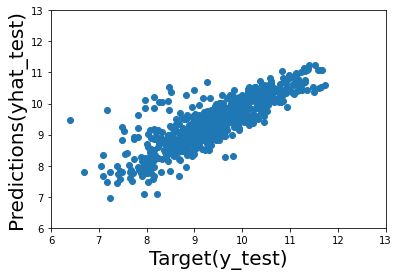

In [41]:
plt.scatter(y_test, yhat_test, alpha = 1)
plt.xlabel('Target(y_test)', fontsize = 20)
plt.ylabel('Predictions(yhat_test)', fontsize = 20)
plt.ylim(6,13)
plt.xlim(6,13)
plt.grid(False)

In [42]:
performance = pd.DataFrame(np.exp(yhat_test), columns=['Prediction'])
y_test = y_test.reset_index(drop=True)
performance['Target'] = np.exp(y_test)
performance['Residual'] = performance['Target'] - performance['Prediction']
performance['Difference%'] = np.absolute(performance['Residual']/performance['Target']*100)
performance.round(2)

,Prediction,Target,Residual,Difference%
0,19848.85,22500.0,2651.15,11.78
1,6060.52,3000.0,-3060.52,102.02
2,13098.48,12600.0,-498.48,3.96
3,8672.04,10500.0,1827.96,17.41
4,25304.43,18950.0,-6354.43,33.53
...,...,...,...,...
780,14510.71,9200.0,-5310.71,57.73
781,19899.84,30650.0,10750.16,35.07
782,3756.39,3700.0,-56.39,1.52
783,12563.10,12400.0,-163.10,1.32


In [43]:
performance.describe()

,Prediction,Target,Residual,Difference%
count,785.000000,785.000000,785.000000,785.000000
mean,15835.130314,18104.718204,2269.587890,45.134638
std,12301.384064,18701.406345,10591.188474,112.425114
min,1057.652187,600.000000,-33465.230844,0.121007
25%,7520.504896,7000.000000,-2163.110925,12.691719
50%,12044.728447,11500.000000,388.154778,24.402360
75%,20790.049401,22500.000000,3813.015340,42.251737
max,76508.003814,125000.000000,84954.269532,2059.658389


In [45]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' %x)
performance.sort_values(by = ['Difference%'])

,Prediction,Target,Residual,Difference%
640,12915.61,12900.00,-15.61,0.12
62,40069.14,39999.00,-70.14,0.18
349,13173.86,13200.00,26.14,0.20
188,30564.78,30500.00,-64.78,0.21
342,17597.05,17639.47,42.42,0.24
286,38200.97,38300.00,99.03,0.26
195,23262.62,23200.00,-62.62,0.27
613,17742.64,17800.00,57.36,0.32
7,10034.18,10000.00,-34.18,0.34
526,8547.72,8500.00,-47.72,0.56


Things to note

On a average this model is decent at predicting the price of used cars, although it faulted at predicting the price of used cars that have a low target price. 